# **Web Analytics Report - For a Travel Aggregator**

**The following analysis is done for a travel aggregator that earns revenue from PPC (Pay Per Click) model, i.e., Every time a user clicks the link and traverses into the partner's website for booking hotel rooms, the aggregator receives revenue from the partner. **

**Objective of this analysis is **

* To understand existing patterns in the web data across different platforms
* To assess the impact of a couple of changes on their website during the months of Feb & Apr done using traditional AB testing by measuring different KPIs that are important for the business


**Data Provided**

One csv file for each of these two tests, containing the AB test results collected in terms of main base metrics. The data is aggregated by ymd (the date), platform (thecountry-specific platform), and group (control or test). These are the first 3 columns of the files. The remaining columns contain the base metrics:

* visits - how many website visits from our users were logged
* clicks - how many times our users clicked in one of our prices and were re-directed to the website of one of our advertisers. Note that each individual visit may or may not include clicks.
* revenue - how much money (in EUR) was generated. Assumption is that this revenue is generated under a CPC model.
* bookings - how many accommodation reservations were made in our advertisers’ websites.
* booking_amount - the corresponding amount (in EUR) paid by the users for the accommodation reservations.


**Analysis**

Focus is to address below questions that will enable the business to take strategic actions accordingly. Two separate analyses are done.

**1. Data Exploration**
* What is the most valuable platform? Why?
* What are the global and platform average revenue per click?
* Do you find any trend in the data?
* Which relation do you think exists between clicks and bookings? And what abo

**2. A/B test analysis**

For each of the 2 tests:
* Which metrics would you use to evaluate the performance of the test group?
* Can you summarise the performance of the tests?
* What would be your recommendation regarding the decision for the test? (and why?)
    * Roll-out the new feature to all users immediately
    * Develop the feature further before testing again
    * Run the test for a longer period of time


*Below analyses attempts to answer the above questions using Exploratory Data Analysis (EDA) and statistical methods in a very classic way for easier interpretation and understanding by all readers.*

**Importing Libraries & Data required for the analysis**

In [1]:
## Importing required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math as mt
from scipy import stats
from scipy.stats import norm
from statsmodels.stats import weightstats as stests

In [2]:
## Data Import
feb = pd.read_csv("../input/marketplace/test1.csv")
may = pd.read_csv("../input/marketplace/test2.csv")

**Sanity checks before processing the data to understand data integrity and consistency**

In [3]:
##Understanding data size
print("Actual data size")
print("Feb: ",feb.shape)
print("May: ",may.shape)

Actual data size
Feb:  (336, 8)
May:  (372, 8)


In [4]:
##Checking for any duplicates
print("After dropping duplicates")
print("Feb: ",feb[['ymd','platform','group']].drop_duplicates().shape)
print("May: ",may[['ymd','platform','group']].drop_duplicates().shape)
print("No duplicates found!")

After dropping duplicates
Feb:  (336, 3)
May:  (372, 3)
No duplicates found!


In [5]:
#Checking for null values
print("Feb:")
print(feb.isnull().sum())
print("")
print("May:")
print(feb.isnull().sum())
print("No NULL values found!")

Feb:
ymd               0
platform          0
group             0
visits            0
clicks            0
revenue           0
bookings          0
booking_amount    0
dtype: int64

May:
ymd               0
platform          0
group             0
visits            0
clicks            0
revenue           0
bookings          0
booking_amount    0
dtype: int64
No NULL values found!


In [6]:
##Check for consistent data in both test and control group
print("Feb")
print(feb.group.value_counts())
print("May")
print(may.group.value_counts())
print("Test and control group have same records count for Apr & May months")

Feb
control    168
test       168
Name: group, dtype: int64
May
control    186
test       186
Name: group, dtype: int64
Test and control group have same records count for Apr & May months


In [7]:
##Check for consistent data in both test and control group in every platform
print('Feb')
print(feb.groupby(['platform','group']).count())
print("May")
print(may.groupby(['platform','group']).count())
print("\n Test and Control group performance is captured on all days during Apr & May")

Feb
                  ymd  visits  clicks  revenue  bookings  booking_amount
platform group                                                          
AU       control   28      28      28       28        28              28
         test      28      28      28       28        28              28
BR       control   28      28      28       28        28              28
         test      28      28      28       28        28              28
DE       control   28      28      28       28        28              28
         test      28      28      28       28        28              28
JP       control   28      28      28       28        28              28
         test      28      28      28       28        28              28
UK       control   28      28      28       28        28              28
         test      28      28      28       28        28              28
US       control   28      28      28       28        28              28
         test      28      28      28       28 

In [8]:
## Data preprocessing & Feature engineering
feb['month'] = 'feb'
may['month'] = 'may'

data = feb.append(may)

data['rpc'] = round(data['revenue']/data['clicks'],4)
data['rpv'] = round(data['revenue']/data['visits'],4)
data['cpv'] = round(data['clicks']/data['visits'],4)
data['bpv'] = round(data['bookings']/data['visits'],4)
data['bpc'] = round(data['bookings']/data['clicks'],4)
data['amt_per_booking'] = round(data['booking_amount']/data['bookings'],4)
data['ymd'] = pd.to_datetime(data['ymd'])

data['weekday'] = data[['ymd']].apply(lambda x: dt.datetime.strftime(x['ymd'], '%A'), axis=1)
data['wom'] = data.ymd.apply(lambda d: (d.day-1) // 7 + 1)
data['weeknum'] = data['month'] + data['wom'].astype(str)

data.head

<bound method NDFrame.head of            ymd platform    group  visits  clicks        revenue  bookings  \
0   2019-02-01       US     test   19219   17289   23752.189583      1072   
1   2019-02-01       US  control  204923  184276  250169.068436     11775   
2   2019-02-01       DE     test   14788   13273   10381.106892       492   
3   2019-02-01       DE  control  106112   95555   72563.524075      3621   
4   2019-02-01       UK     test   13823   12441   10472.761095       486   
..         ...      ...      ...     ...     ...            ...       ...   
367 2019-05-31       AU  control   52765   47560   49945.837451      2382   
368 2019-05-31       BR     test    3220    2804    1300.393503        95   
369 2019-05-31       BR  control   29971   26943   10280.212939       767   
370 2019-05-31       JP     test    4596    3986    3389.562888       103   
371 2019-05-31       JP  control   45121   40554   26687.246918       874   

     booking_amount month     rpc     rpv    

**Exploratory Data Analysis**

Below analysis to answer the EDA questions are based only on control group data as test group is not the right sample to include for understanding the behavior trend

# **Question1: What is the most valuable platform? Why?**

**Approach:** Since the definition for 'Valuable' platform is not clearly defined, general key metrics that a website keeps track of are compared against different platforms  to identfy the valuable platform.

* Key Metrics: Visits, Clicks Per Visit, Revenue, Revenue Per Click 
* Since revenue is based on CPC model (as per assumption), Bookings & Booking Per Click are not considered as major KPIs for measuring the platforms

**Bar plots are a quick & easy way to visualize the aggregated metrics across different platforms during Feb and May**

<Figure size 432x288 with 0 Axes>

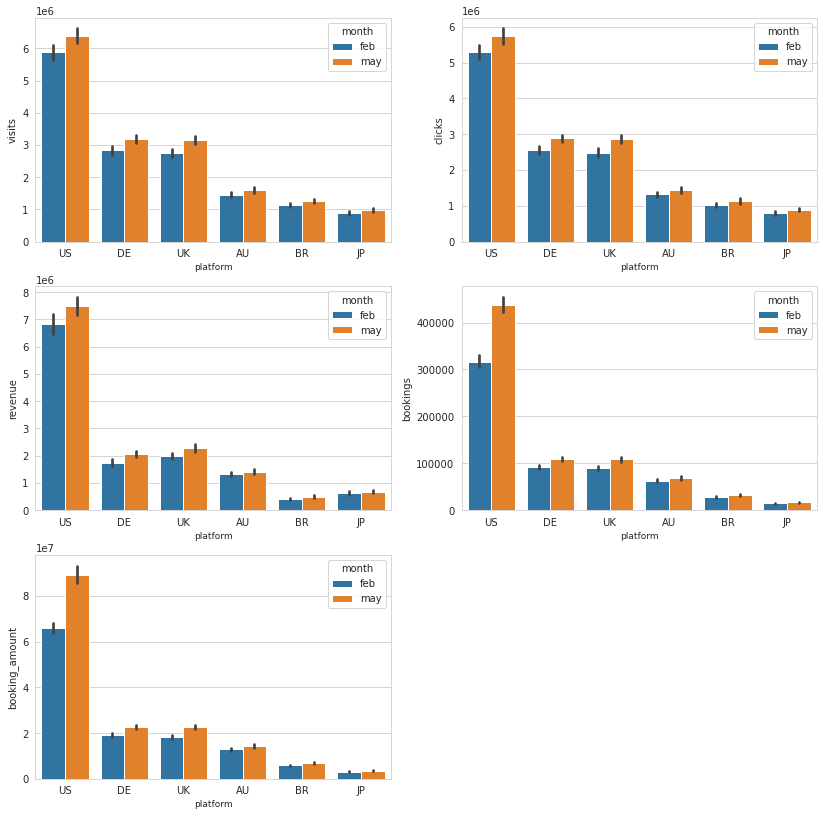

In [9]:
#Feb vs May Plots to view top platforms at every metric level (summed metrics)
def plot_feature_bar(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(3,2,i)
        sns.barplot(x="platform",y=feature,hue="month", data=df,estimator=sum)
        plt.xlabel("platform", fontsize=9)
    plt.show();
    
features=['visits', 'clicks', 'revenue', 'bookings','booking_amount']
plot_feature_bar(data[data['group']=='control'], features)

**Bar plots to visualize calculated KPI averages across platforms**

<Figure size 432x288 with 0 Axes>

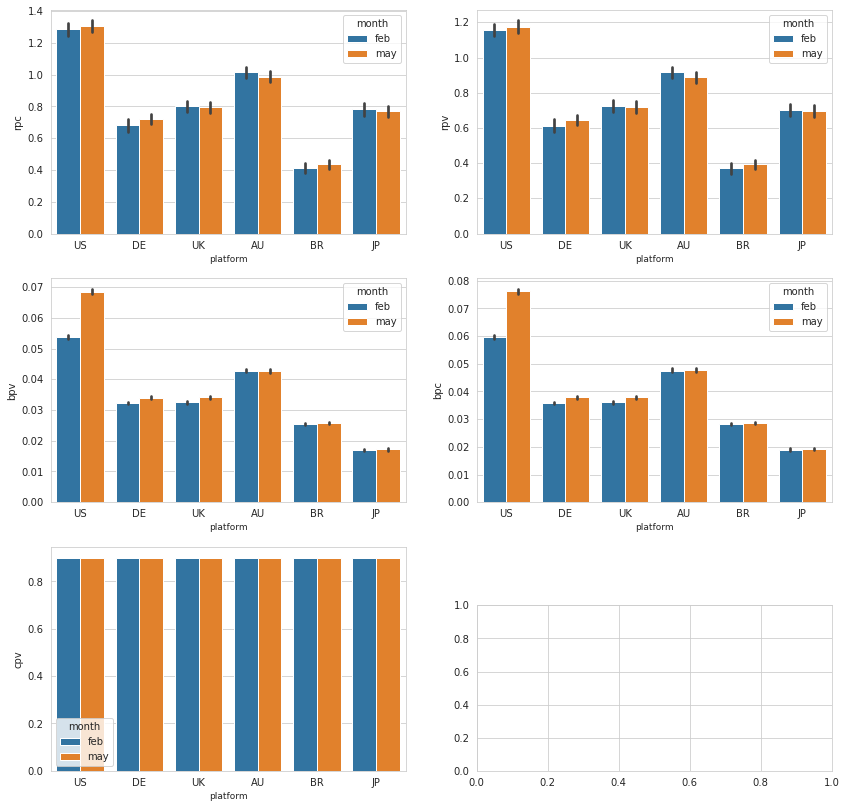

In [10]:
#Feb vs May Plots to view top platforms at every metric level (mean metrics)
def plot_feature_bar(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,2,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(3,2,i)
        sns.barplot(x="platform",y=feature,hue="month", data=df)
        plt.xlabel("platform", fontsize=9)
    plt.show();
    
features=['rpc','rpv','bpv','bpc','cpv']
plot_feature_bar(data[data['group']=='control'], features)

**Boxplots to understand the above KPIs' effect on different platforms without hampered by outliers**
* This help in viewing the metrics by eliminating seasonal effects, if any

<Figure size 432x288 with 0 Axes>

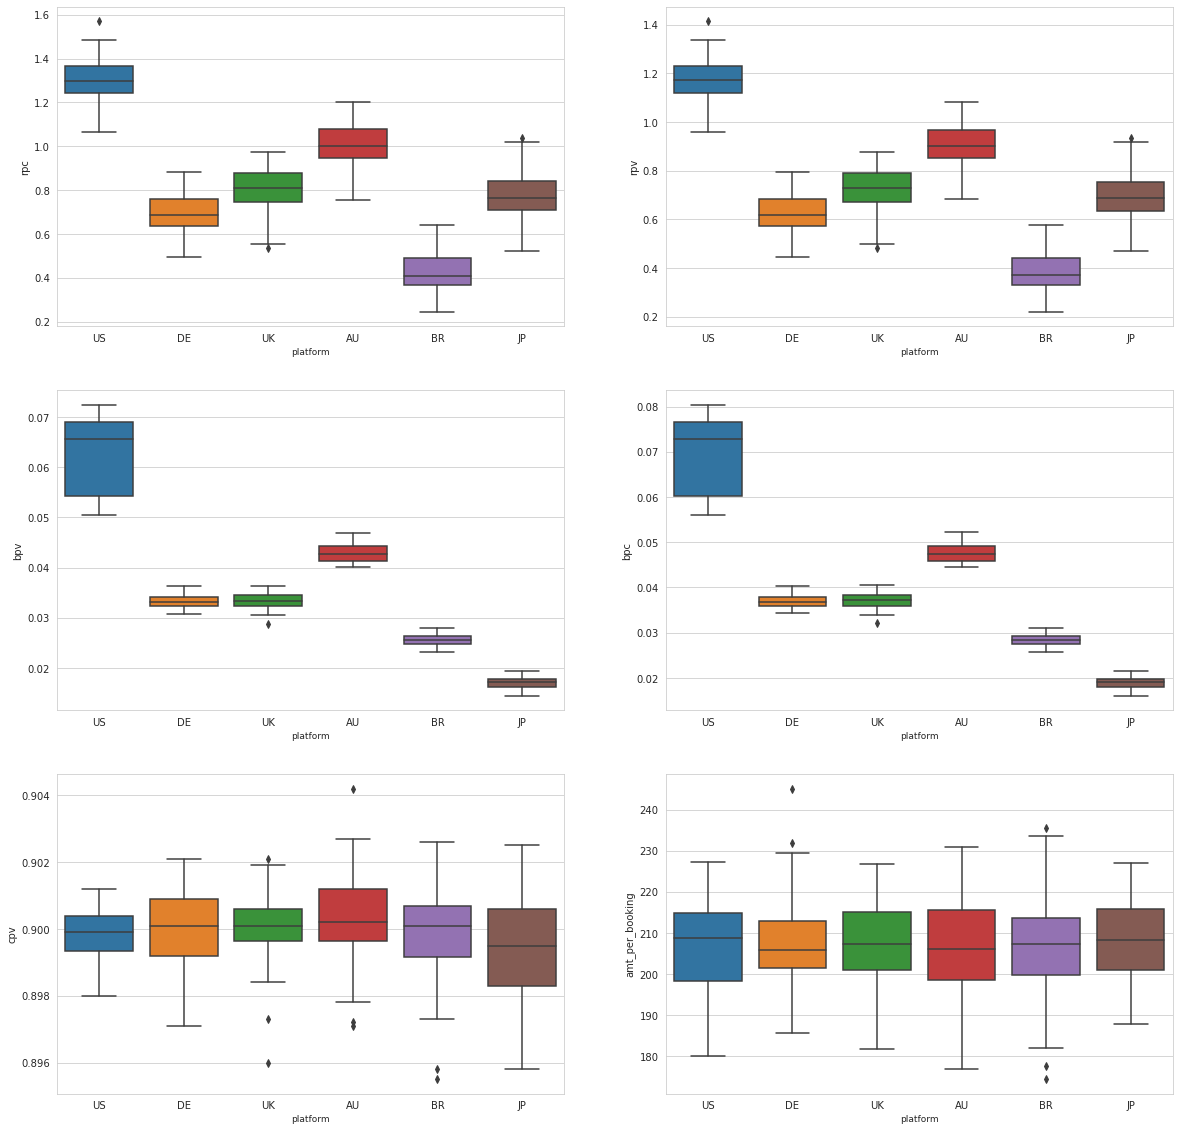

In [11]:
#Understanding the KPIs distribution among platforms without the effect of outliers
def plot_feature_box(df,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(20,20))

    for feature in features:
        i += 1
        plt.subplot(3,2,i)
        sns.boxplot(x='platform',y=feature, data=df)
        plt.xlabel('platform', fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features=['rpc','rpv','bpv','bpc','cpv','amt_per_booking']
plot_feature_box(data[(data['group']=='control')],features)

**Observations from EDA plots:**

**Aggregated Metrics:** 
* US is the biggest market with respect to all metrics - Clicks, Visits, Bookings, Booking Amount & Revenue.

**Average Metrics:**
* Clicks Per Visit is almost same (~90%) across all platforms. Hence clicks and visits exhibit same relationship with other metrices.
* Revenue Per Click is highest for US with an average of 1.3
* Bookings Per Click is highest for US with an average of 7%

**Conclusion: US is the most valuable platform (from CPV, RPC, Overall Clicks & Visits)**

**What else can be done?** Market size information (population size of platforms) can be used to evaluate the platforms better in addition to the given metrics.


# Question 2: What are the global and platform average revenue per click?

Approach: 
* To check weekly seasonality in the Revenue Per Click (RPC) metric at global and platform level
* Calculate RPC at weekly level and taken an average to quantify average global and platform RPC

<Figure size 432x288 with 0 Axes>

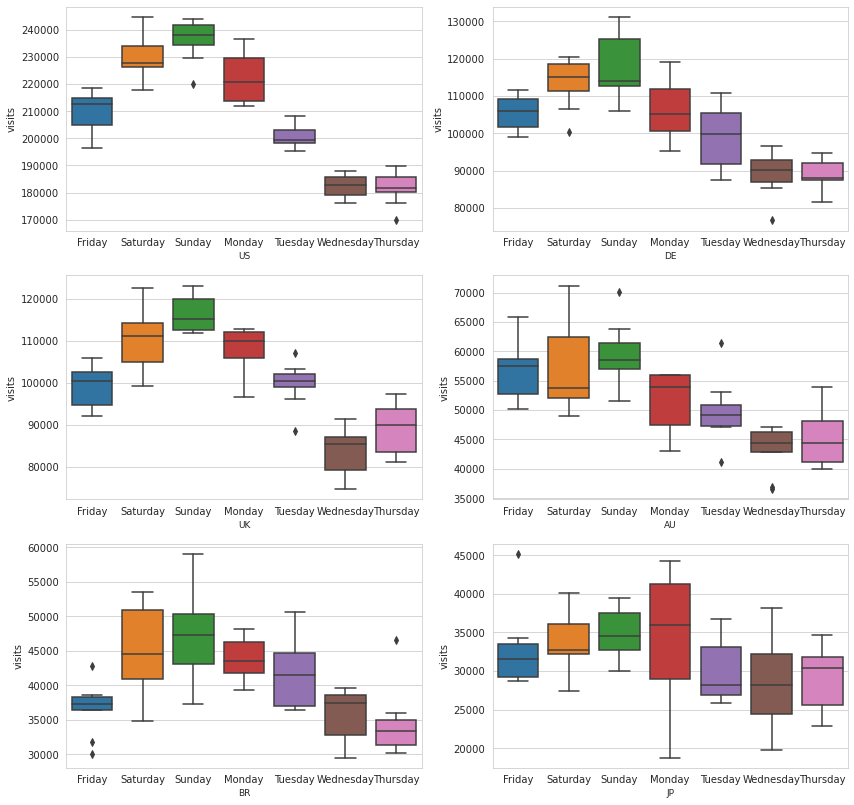

<Figure size 432x288 with 0 Axes>

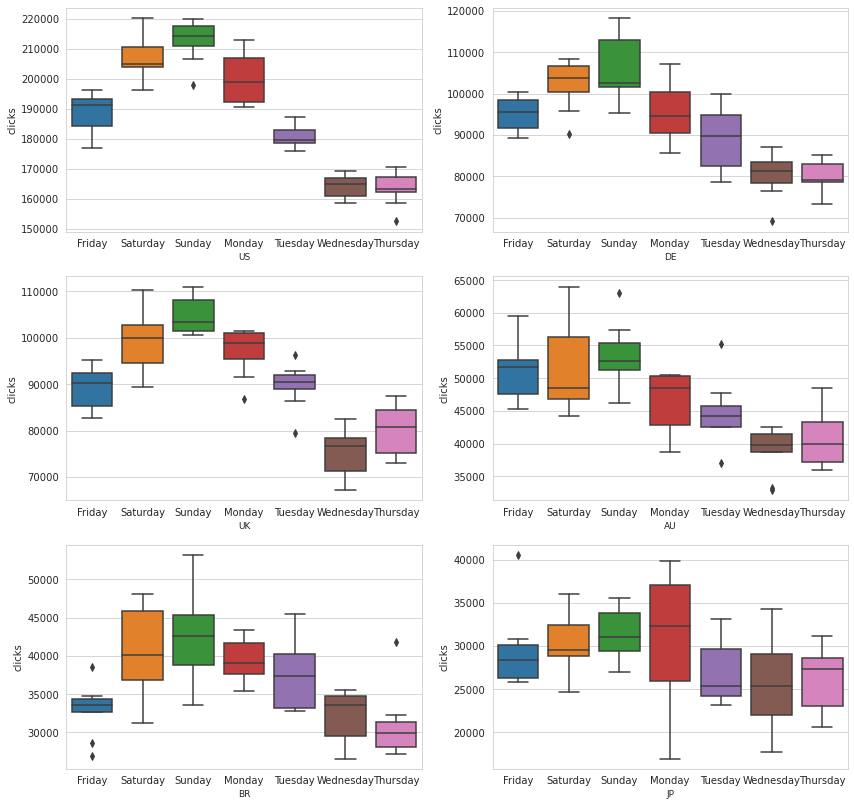

<Figure size 432x288 with 0 Axes>

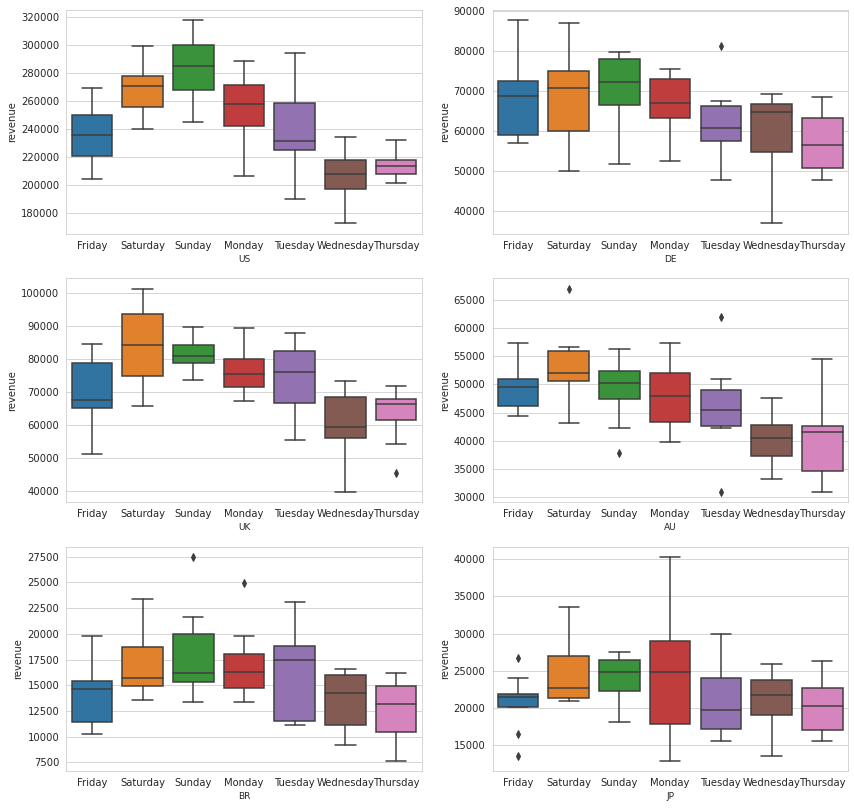

<Figure size 432x288 with 0 Axes>

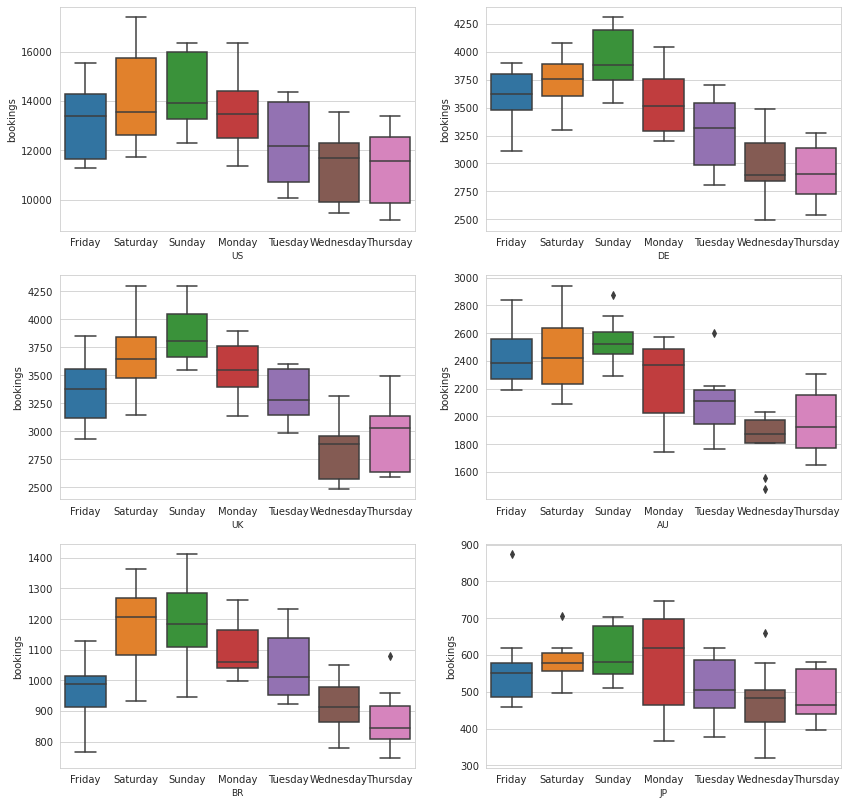

<Figure size 432x288 with 0 Axes>

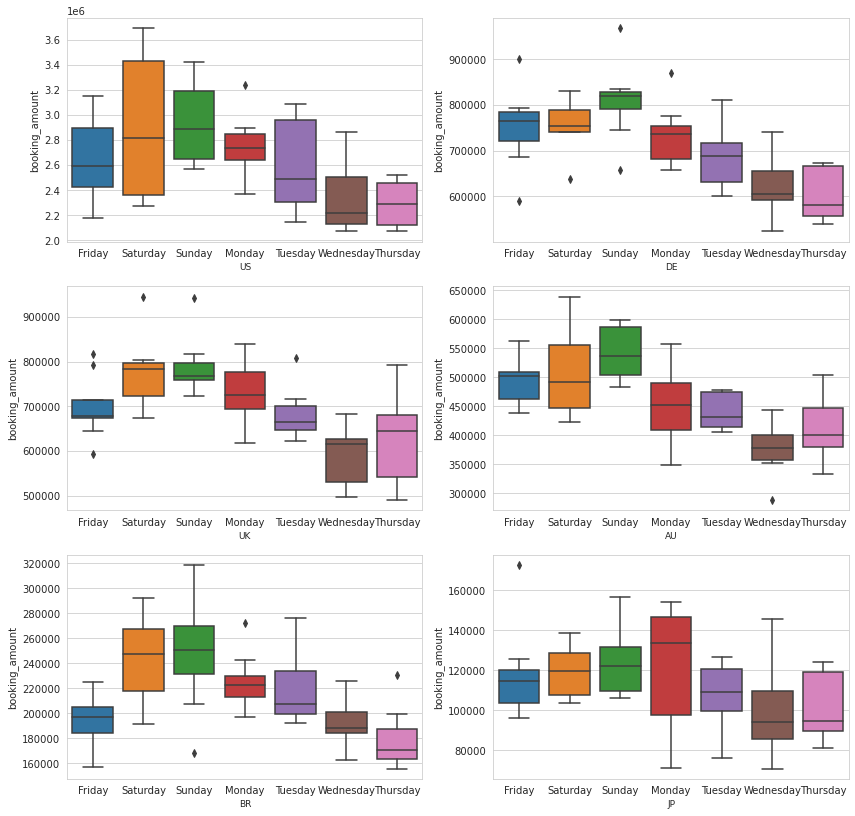

<Figure size 432x288 with 0 Axes>

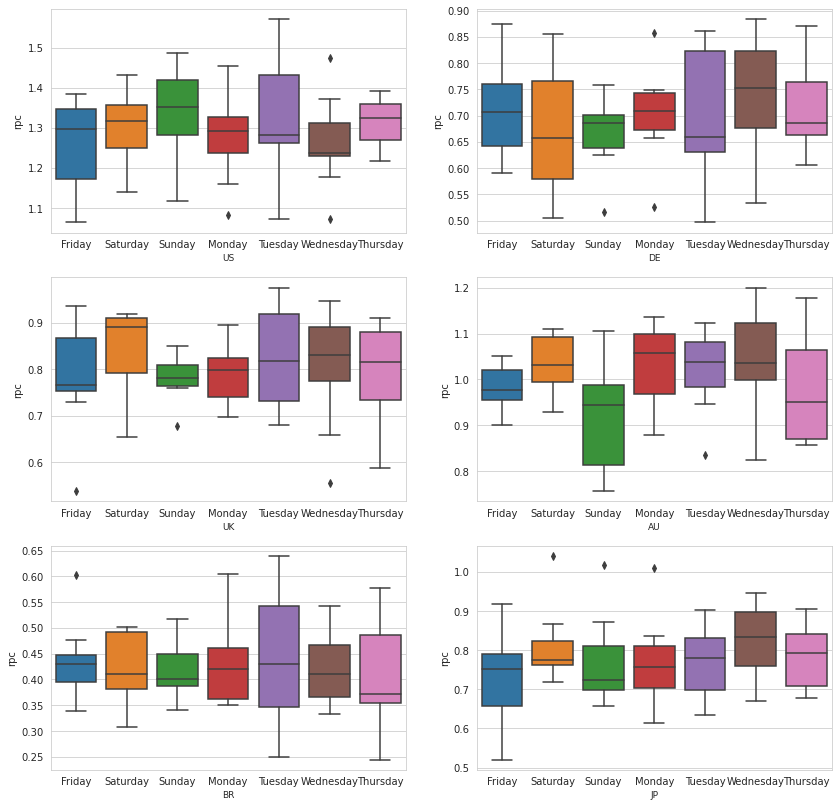

<Figure size 432x288 with 0 Axes>

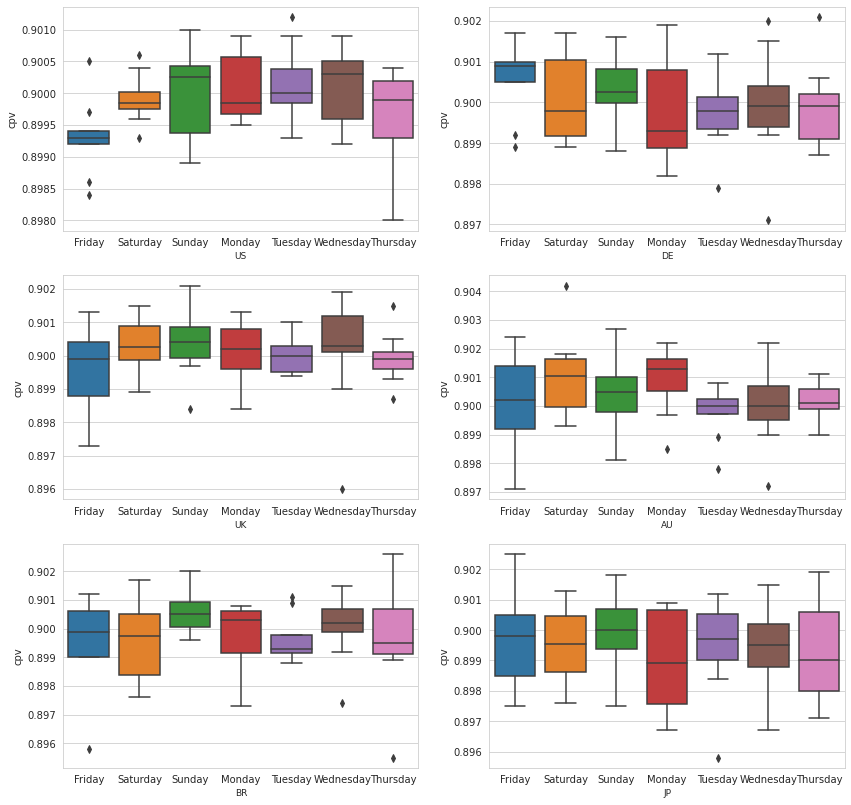

<Figure size 432x288 with 0 Axes>

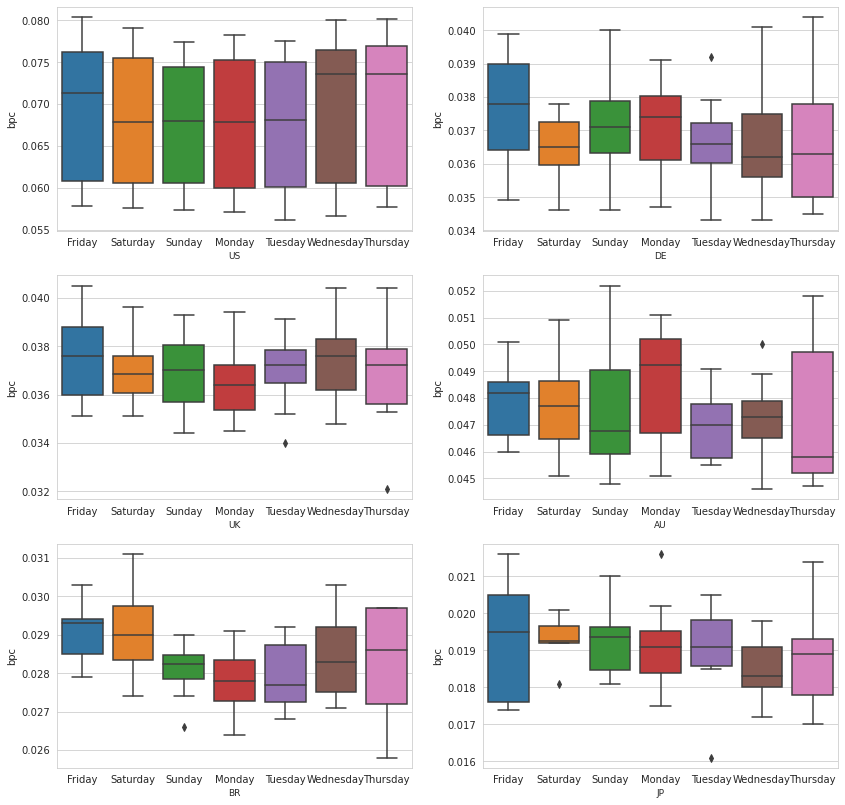

In [12]:
## Weekly plot of Revenue & Clicks across platforms
def plot_feature_box(df,features,metric):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(14,14))

    
    for feature in features:
        i += 1
        plt.subplot(3,2,i)
        sns.boxplot(x='weekday',y=metric, data=df[df['platform']==feature])
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = data.platform.unique().tolist()

plot_feature_box(data[(data['group']=='control') ],features,'visits')
plot_feature_box(data[(data['group']=='control') ],features,'clicks')
plot_feature_box(data[(data['group']=='control') ],features,'revenue')
plot_feature_box(data[(data['group']=='control') ],features,'bookings')
plot_feature_box(data[(data['group']=='control') ],features,'booking_amount')
plot_feature_box(data[(data['group']=='control') ],features,'rpc')
plot_feature_box(data[(data['group']=='control') ],features,'cpv')
plot_feature_box(data[(data['group']=='control') ],features,'bpc')

The revenue and clicks metrics shows clear seasonality (high during the Saturdays, Sundays & Mondays), although RPC doesn't show similar pattern.

In [13]:
#Grouping data on a weekly basis due to clear seasonality
weekly_platform_data = data.groupby(['platform', 'month', 'wom', 'group'], as_index=False)['revenue','clicks','visits','bookings','booking_amount'].sum()
weekly_platform_data['rpc'] = round(weekly_platform_data['revenue']/weekly_platform_data['clicks'],2)
weekly_platform_data.platform = weekly_platform_data.platform.astype('category')
weekly_platform_data['platform'] = weekly_platform_data['platform'].cat.reorder_categories(data.platform.unique().tolist())
data.platform = data.platform.astype('category')
data['platform'] = data['platform'].cat.reorder_categories(data.platform.unique().tolist())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<Figure size 432x288 with 0 Axes>

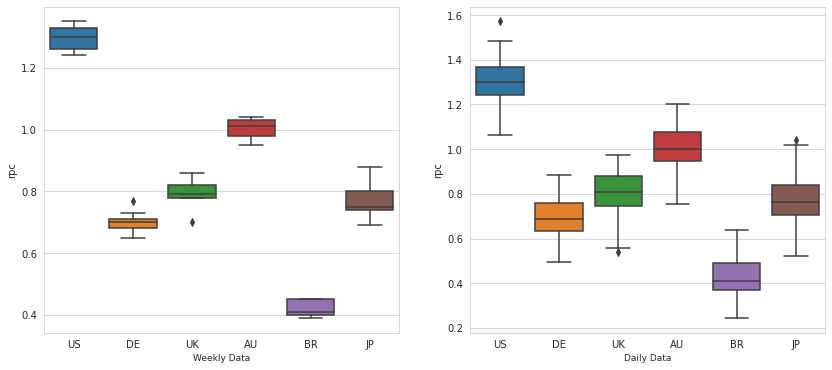

In [14]:
#Multivariate Plots
def plot_feature_box(df1,df2,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(14,6))

    for feature in features:
        i += 1
        plt.subplot(1,2,i)
        sns.boxplot(y=feature, x='platform', data=df1)
        plt.xlabel('Weekly Data', fontsize=9)
        i=i+1
        plt.subplot(1,2,i)
        sns.boxplot(y=feature,x='platform', data=df2)
        plt.xlabel('Daily Data', fontsize=9)
    plt.show();
    
features = ['rpc']
plot_feature_box(weekly_platform_data[(weekly_platform_data['group']=='control')],data[(data['group']=='control')],features)

Above graphs shows how the effect of outliers are handled when the RPC is calculated on a weekly data than on a daily data. Of course, the difference is not huge for this dataset but it is always a best practice to check for seasonality and calculate averages.

In [15]:
#Grouping data on a weekly basis due to clear seasonality
weekly_global_data = data.groupby(['month', 'wom', 'group'], as_index=False)['revenue','clicks','visits','bookings','booking_amount'].sum()
weekly_global_data['rpc'] = round(weekly_global_data['revenue']/weekly_global_data['clicks'],2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<Figure size 432x288 with 0 Axes>

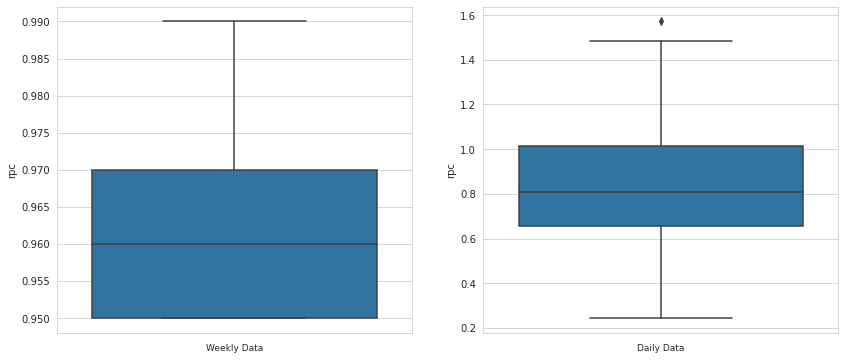

In [16]:
#Multivariate Plots
def plot_feature_box(df1,df2,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(14,6))

    for feature in features:
        i += 1
        plt.subplot(1,2,i)
        sns.boxplot(y=feature, data=df1)
        plt.xlabel('Weekly Data', fontsize=9)
        i=i+1
        plt.subplot(1,2,i)
        sns.boxplot(y=feature, data=df2)
        plt.xlabel('Daily Data', fontsize=9)
    plt.show();
    
features = ['rpc']
plot_feature_box(weekly_global_data[(weekly_global_data['group']=='control')],data[(data['group']=='control')],features)

In [17]:
global_rpc = round(weekly_global_data[(weekly_global_data['group']=='control')]['rpc'].mean(),3)
platform_rpc = weekly_platform_data[(weekly_platform_data['group']=='control')].groupby([('platform')])['rpc'].mean().round(3)

print('Global Revenue Per Click: ', global_rpc)
print()
print("Platform Revenue Per Click:\n", platform_rpc)

Global Revenue Per Click:  0.963

Platform Revenue Per Click:
 platform
US    1.298
DE    0.698
UK    0.794
AU    1.001
BR    0.422
JP    0.772
Name: rpc, dtype: float64


# Question 3: Do you find any trend in the data?

**Approach:** Time series plots tells a great story about the trend of different metrics over a period of time

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

<Figure size 432x288 with 0 Axes>

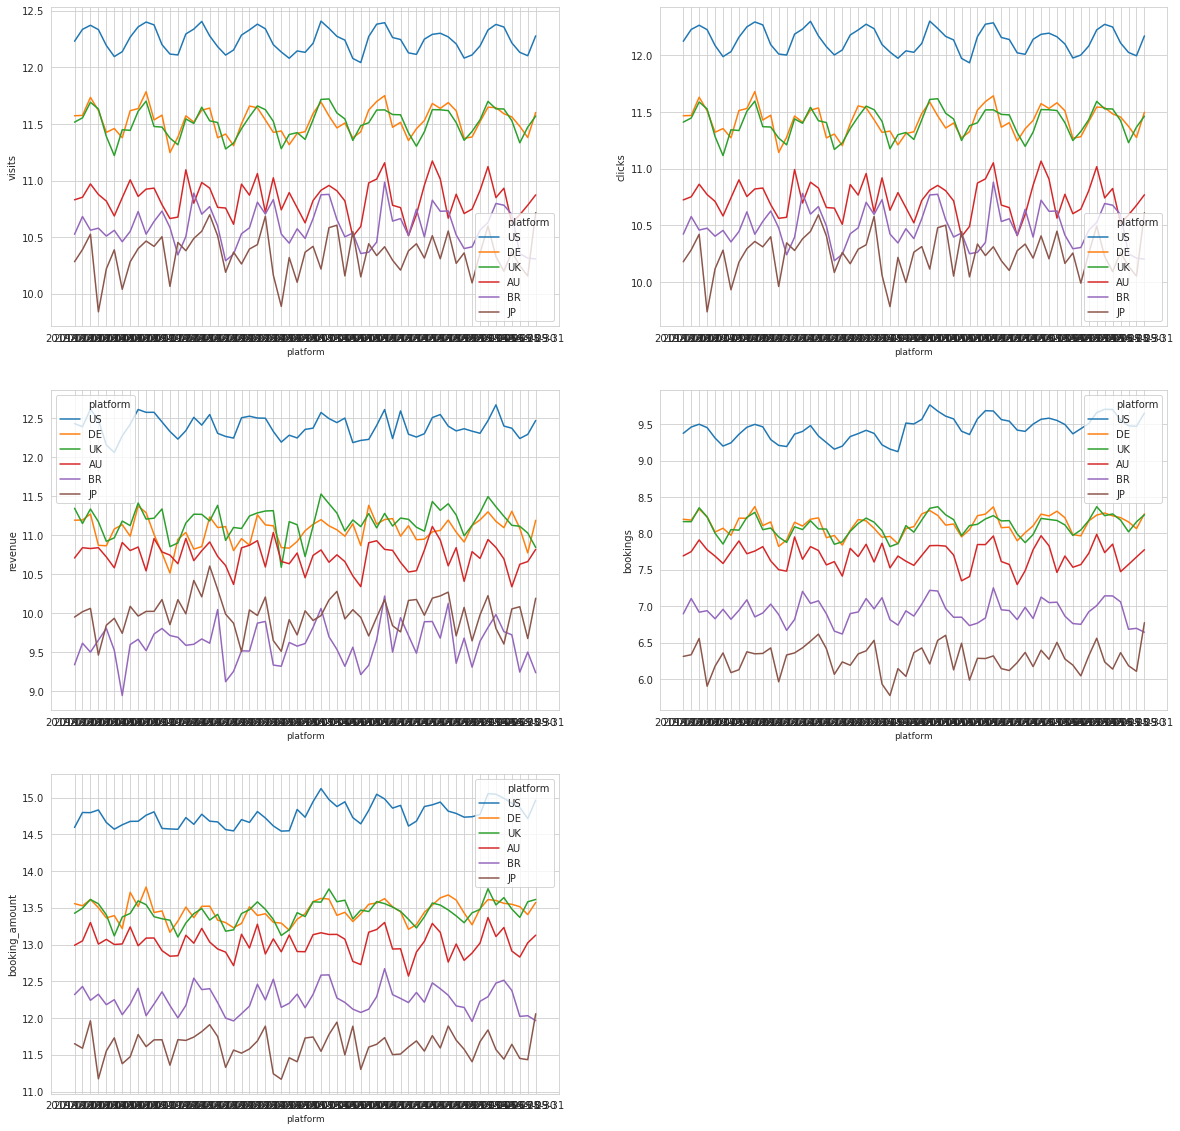

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

<Figure size 432x288 with 0 Axes>

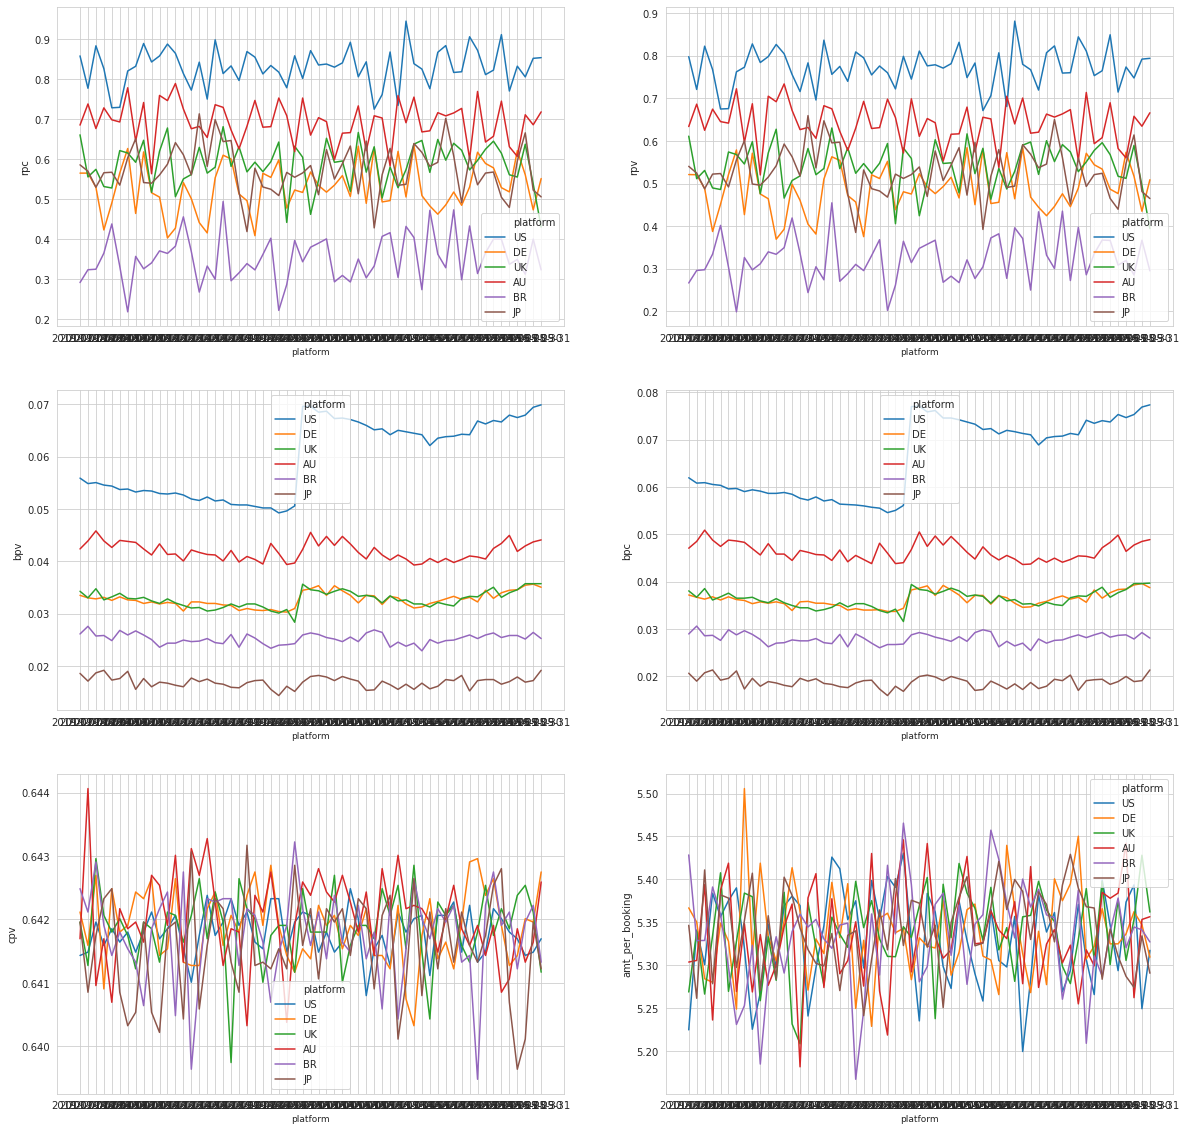

In [18]:
def plot_feature_timeseries(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(20,20))
    df['ymd'] = df['ymd'].dt.strftime('%Y-%m-%d')

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(3,2,i)
        df[feature] = np.log(df[feature]+1)
        sns.lineplot(x="ymd",y=feature,hue="platform", data=df)
        plt.xlabel("platform", fontsize=9)
    plt.show();
    
features=['visits','clicks','revenue','bookings','booking_amount']
plot_feature_timeseries(data[(data['group']=='control')], features)

features=['rpc','rpv','bpv','bpc','cpv','amt_per_booking']
plot_feature_timeseries(data[(data['group']=='control')], features)

**Observation from the above trends:**

* A clear **weekly seasonality** can be seen especially in Visits, which explains the same level of seasonality for other metrics like Clicks, Revenue, Bookings and Booking Amount. 
    * Saturday, Sunday & Monday generate highest number of Clicks, Visits, Revenue, Bookings & Booking Amount. The metrics decline gradually along the rest of the week.   
    * This consistent pattern is evident from the above daily time series plot and weekly boxplots across all platforms.
* Revenue Per Click for JP & AU, although the visits and clicks are less compared to other platforms
    * Although Japan has the least number of visits, clicks, bookings and booking amount, the revenue that it generates is higher than that of Brazil. This is clearly due to higher Revenue Per Click.
    * Although AU observes lesser number of clicks & visits compared to DE & UK, the revenue that it generates is closer to the latter. This is clearly due to higher Revenue Per Click.
* A clear increasing trend for Bookings & Booking Amount is evident for US, followed by UK & DE. Although not a comparable shift in trend (a flat trend is observed) is visible for visits and clicks for the respective platforms.
    * This is clearly due to the sudden increase in Bookings Per Click in the US, followed by UK & DE during May.
* Revenue Per Click shows an increasing trend in the US and hence Revenue Per Vist. Similarly DE and BR shows a slightly increasing trend for the same metrics.
* Clicks Per Visit has remained almost flat at ~90% across all platforms.
* Bookings Amount has remained almost flat between 200 and 220.
* UK & DE have similar trend and size (market behavior seems to be the same).

**Recommendation:**
Since CPV is flat at 90% across all platforms (90% visitors click the link/button), main focus should be on bringing in more visitors to increase the clicks and hence the revenue (under the assumption of CPC model) for achieving easier lift in the metrics.

*Note: The +/- trend numbers to quantify the shift in trend can be done using a WoW (Week over Week) and MoM (Month over Month) analysis and significance of same can be tested using statistical hypothesis testing. Restricting to my thoughts here with just a time series trend anaysis, in the interest of time.*

# Question 4: Which relation do you think exists between clicks and bookings? And what about visits and bookings? Which one would you consider as more valuable KPI?

**Approach:** Since the amount of data points is good enough to explain the relationship between metrices and also due to the strong linear relationship that exists, Correlation Analysis can be a useful measurement to identify the relationship for the given data. 

To quantify the effect of clicks on bookings, a simple regression analysis can be done removing the effect of visits. However, to answer the above question, I have just restricted to Correlation Analysis.

In [19]:
## Correlation Analysis
print("Correlation between Clicks and Bookings is",round(data['clicks'].corr(data['bookings']),2))
print("Correlation between Visits and Bookings is",round(data['visits'].corr(data['bookings']),2))
print("Correlation between Clicks and Visits is",round(data['clicks'].corr(data['visits']),2))

Correlation between Clicks and Bookings is 0.95
Correlation between Visits and Bookings is 0.95
Correlation between Clicks and Visits is 1.0


As expected there is a very strong positive correlation that exists between the metrices
* Clicks & Visits - As seen earlier, 90% of the visitors click the link/button. Hence a perfect correlation of +1 exists, i.e., Clicks can be calculated directly by Visits*0.9
    * Hence, the same level of relationship exists for Clicks & Bookings and Visits & Bookings - +0.95
 
 
* Clicks vs Bookings should be considered as the valuable KPI - Bookings is directly dependent on clicks and indirectly on visits.

# AB Test Analysis

**Approach:** To compare the performance of control and test group using key metrics for Apr and May months seperately using statistical hypothesis testing (z test)

**Reasons to choose Z score (and not T test):** 

* Metrics are found to be (almost) normally distributed
* Entire population statistics is provided (The problem statement in the pdf says that control group consitutes of a subset of visits and test group is the corresponding 'remaining' visits). The distribution provides both population mean and standard deviation needed for the hypothesis testing.

**Metrics chosen for AB testing:**
1. Clicks Per Visit - Also, Revenue is assumed to be from CPC model and hence this is a primary metric
2. Bookings Per Click - End goal
Note: Bookings Per Visit is not considered as it is expected to be similar to that of BPC since Clicks = Visits*90%

**Steps:**
1. Compare the CPV & BPC metric between test and control group at global level
2. Calculate the mean difference between the groups
3. From the population standard deviation, calculate standard mean error
4. Calculate Margin of Error for 95% Confidence
5. Check if 0 (no change in means of two groups) falls within the 95% Confidence Interval
    * If yes, then the difference in means is not statistically significant with 95% confidence
    * Otherwise, the difference is statistically significant with 95% confidence    
6. Calcuate Z score and p value to prove the analysis

Above analysis is also done at Platform level (ideal way inorder to avoid missing the real impact of new feature)

**Assumptions:**
1. Control and Test group together constitute the entire population
2. Significance level is kept as 95%
3. Since the Minimum Detectable Effect (MDE) is not provided, tests only prove whether the difference in means is statistically significant and not practically significant
4. Observed difference in means is not due to any external factors and that minimum time needed to assess the performance is already taken care of 

In [20]:
##Function to conduct AB test analysis
def run_ab_test(df, metric1, metric2):
    metric1_sum_control = df[(df['group']=='control')][metric1].sum()
    metric1_sum_test = df[(df['group']=='test')][metric1].sum()
    metric2_sum_control = df[(df['group']=='control')][metric2].sum()
    metric2_sum_test = df[(df['group']=='test')][metric2].sum()
    metric_control = metric1_sum_control/metric2_sum_control
    metric_test = metric1_sum_test/metric2_sum_test
    metric_pooled=(metric1_sum_control+metric1_sum_test)/(metric2_sum_control+metric2_sum_test)
    metric_sd_pooled=mt.sqrt(metric_pooled*(1-metric_pooled)*(1/metric1_sum_control+1/metric1_sum_test))
    ME=round(norm.ppf(1-0.05/2)*metric_sd_pooled,4)
    diff=round(metric_test-metric_control,4)
    z_score = diff/metric_sd_pooled
    p_value = norm.sf(abs(z_score))*2
    #print("Standard Error: ", round(metric_sd_pooled,4))
    print("Change observed in test group is",diff*100,"%")
    print("95% Confidence Interval: [",round((diff*100)-(ME*100),4),",",round((diff*100)+(ME*100),4),"]")
    print ("The change is statistically significant if the CI doesn't include 0")
    print("Z statistic: ", round(z_score,4))
    print("p value: ", p_value)
    if p_value<0.05:
        print("Statistically significant results. Test group shows change of ",diff*100, " with 95% CI [",round((diff*100)-(ME*100),4),",",round((diff*100)+(ME*100),4),"]")
    else:
        print("Statistically insignificant. No significant difference between test and control")
        
    print("")
            

**Conducting AB test for Clicks Per Visit**

Test at global level

In [21]:
## Conducting AB test at global level for Apr and May
for i in data.month.unique():
    print("Month: ",i)
    df = data[data['month']==i]
    run_ab_test(df,"clicks","visits")

Month:  feb
Change observed in test group is 0.02 %
95% Confidence Interval: [ -0.03 , 0.07 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  0.7774
p value:  0.4369267653009984
Statistically insignificant. No significant difference between test and control

Month:  may
Change observed in test group is -2.67 %
95% Confidence Interval: [ -2.72 , -2.62 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  -101.665
p value:  0.0
Statistically significant results. Test group shows change of  -2.67  with 95% CI [ -2.72 , -2.62 ]



<Figure size 432x288 with 0 Axes>

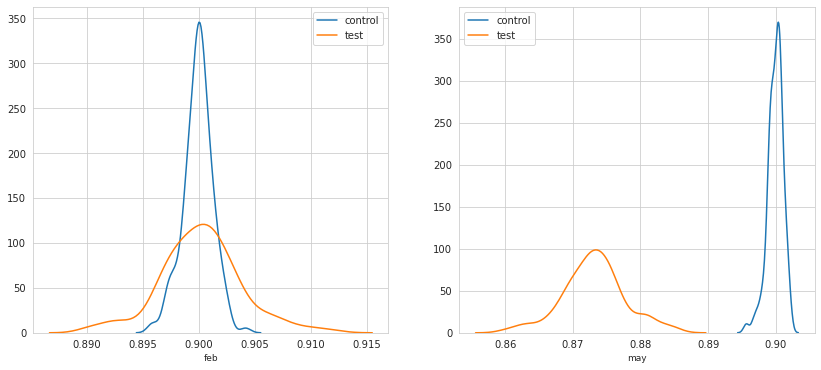

In [22]:
#Density plot to view the distribution shift of CPV between test and control group during Apr & May experimentation
def plot_feature_density(df1,df2,label1,label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(14,6))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(1,2,i)
        sns.distplot(df1.cpv[df1['month']==feature], hist=False,label=label1)
        sns.distplot(df2.cpv[df2['month']==feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = data.month.unique().tolist()
plot_feature_density(data[(data['group']=='control')],data[(data['group']=='test')],'control','test', features)

Above graphs illustrates that
* CPV is almost similar for both test and control group in Feb - Left chart
* Test group has a different CPV mean compared to control in May - Right chart


The spread of data (standard deviation) for test group is wide compared to control group because of the lesser data points in test (10% test sample and 90% control sample observed). Hence, the distribution is good enough for a z test. But collecting more data points (extending the test is required) to validate the same.

Test at Platform level

In [23]:
for i in data.month.unique():
    print("Month: ",i)
    df = data[data['month']==i]
    for j in df.platform.unique():
        print("Platform: ",j)
        df1 = df[df['platform']==j]
        run_ab_test(df1,"clicks","visits")

Month:  feb
Platform:  US
Change observed in test group is 0.04 %
95% Confidence Interval: [ -0.05 , 0.13 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  0.8718
p value:  0.38334166210669174
Statistically insignificant. No significant difference between test and control

Platform:  DE
Change observed in test group is -0.01 %
95% Confidence Interval: [ -0.11 , 0.09 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  -0.1879
p value:  0.8509520138632004
Statistically insignificant. No significant difference between test and control

Platform:  UK
Change observed in test group is -0.04 %
95% Confidence Interval: [ -0.15 , 0.07 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  -0.7394
p value:  0.4596341418661333
Statistically insignificant. No significant difference between test and control

Platform:  AU
Change observed in test group is -0.09 %
95% Confidence Interval: [ -0.27 , 0.09 ]
T

<Figure size 432x288 with 0 Axes>

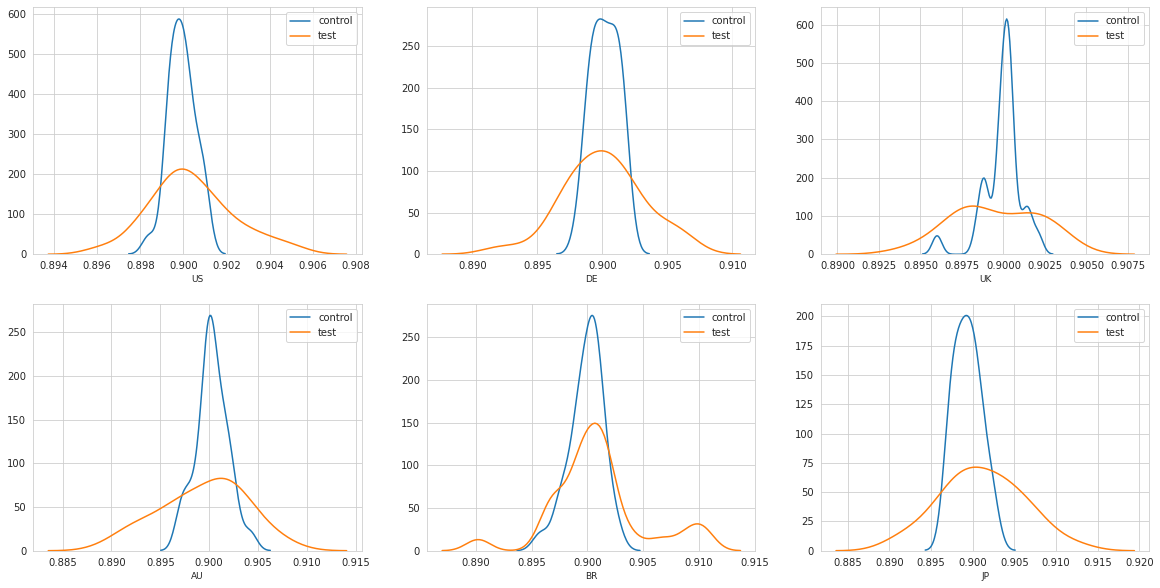

In [24]:
#Density Plots for CPV in Feb at platform level
def plot_feature_density(df1,df2,label1,label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(20,10))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(2,3,i)
        sns.distplot(df1.cpv[(df1['platform']==feature)], hist=False,label=label1)
        sns.distplot(df2.cpv[(df2['platform']==feature)], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = data.platform.unique().tolist()
plot_feature_density(data[(data['group']=='control') & (data['month']=='feb')],data[(data['group']=='test') & (data['month']=='feb')],'control','test', features)

<Figure size 432x288 with 0 Axes>

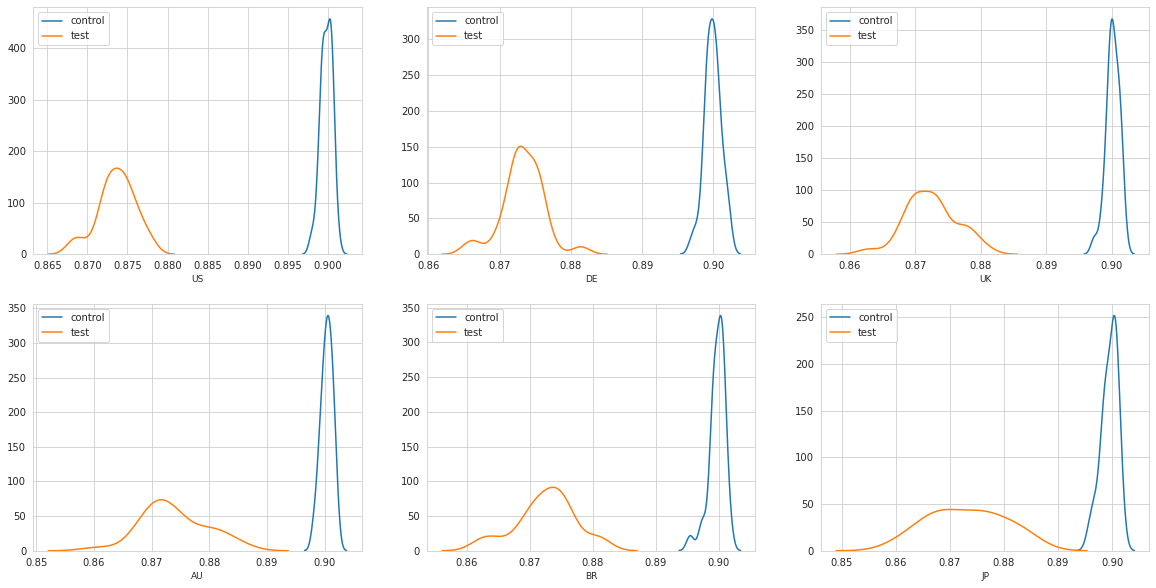

In [26]:
#Density Plots for CPV in May for platform level
def plot_feature_density(df1,df2,label1,label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(20,10))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(2,3,i)
        sns.distplot(df1.cpv[(df1['platform']==feature)], hist=False,label=label1)
        sns.distplot(df2.cpv[(df2['platform']==feature)], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = data.platform.unique().tolist()
plot_feature_density(data[(data['group']=='control') & (data['month']=='may')],data[(data['group']=='test') & (data['month']=='may')],'control','test', features)

**Conducting AB test for Bookings Per Click**

Test at global level

In [27]:
for i in data.month.unique():
    print("Month: ",i)
    df = data[data['month']==i]
    run_ab_test(df,"bookings","clicks")

Month:  feb
Change observed in test group is -0.24 %
95% Confidence Interval: [ -0.41 , -0.07 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  -2.8007
p value:  0.005098790534048829
Statistically significant results. Test group shows change of  -0.24  with 95% CI [ -0.41 , -0.07 ]

Month:  may
Change observed in test group is 0.49 %
95% Confidence Interval: [ 0.33 , 0.65 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  6.03
p value:  1.640003413518024e-09
Statistically significant results. Test group shows change of  0.49  with 95% CI [ 0.33 , 0.65 ]



<Figure size 432x288 with 0 Axes>

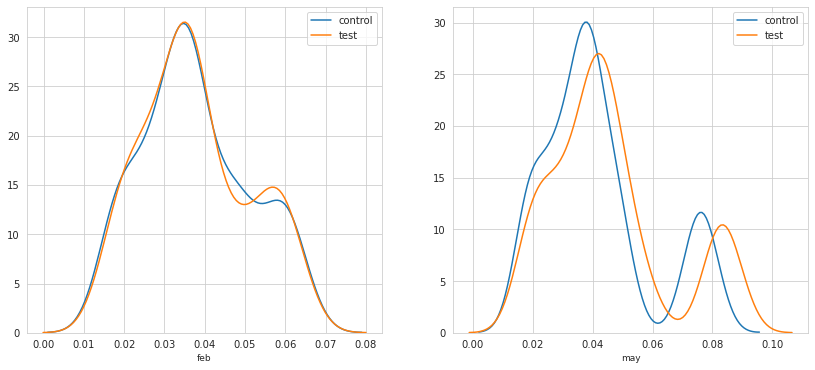

In [28]:
#Density plots to view the difference in BPC between test and control during Apr & May experimentation
def plot_feature_density(df1,df2,label1,label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(14,6))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(1,2,i)
        sns.distplot(df1.bpc[df1['month']==feature], hist=False,label=label1)
        sns.distplot(df2.bpc[df2['month']==feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = data.month.unique().tolist()
plot_feature_density(data[(data['group']=='control')],data[(data['group']=='test')],'control','test', features)

Shift in BPC suring May is clearly visible in the right graph

Test at Platform level

In [29]:
for i in data.month.unique():
    print("Month: ",i)
    df = data[data['month']==i]
    for j in df.platform.unique():
        print("Platform: ",j)
        df1 = df[df['platform']==j]
        run_ab_test(df1,"bookings","clicks")

Month:  feb
Platform:  US
Change observed in test group is -0.04 %
95% Confidence Interval: [ -0.33 , 0.25 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  -0.269
p value:  0.7879347258389489
Statistically insignificant. No significant difference between test and control

Platform:  DE
Change observed in test group is 0.01 %
95% Confidence Interval: [ -0.33 , 0.35 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  0.0574
p value:  0.954236324135531
Statistically insignificant. No significant difference between test and control

Platform:  UK
Change observed in test group is 0.0 %
95% Confidence Interval: [ -0.35 , 0.35 ]
The change is statistically significant if the CI doesn't include 0
Z statistic:  0.0
p value:  1.0
Statistically insignificant. No significant difference between test and control

Platform:  AU
Change observed in test group is 0.01 %
95% Confidence Interval: [ -0.56 , 0.58 ]
The change is statisticall

<Figure size 432x288 with 0 Axes>

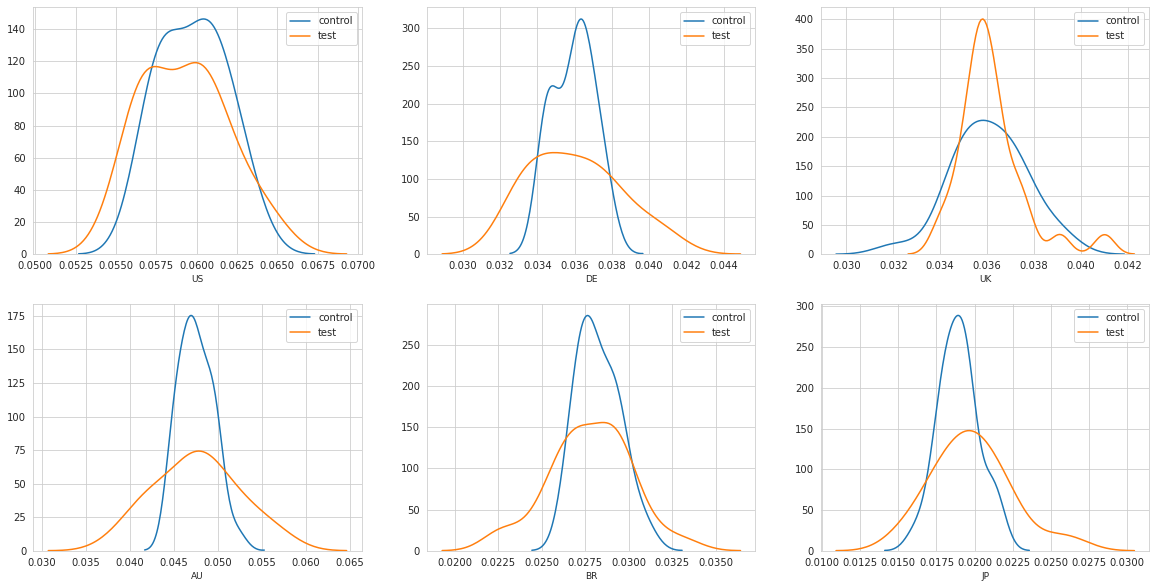

In [30]:
#Density plots to view the difference in BPC between test and control during Apr & May experimentation
def plot_feature_density(df1,df2,label1,label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(20,10))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(2,3,i)
        sns.distplot(df1.bpc[(df1['platform']==feature)], hist=False,label=label1)
        sns.distplot(df2.bpc[(df2['platform']==feature)], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = data.platform.unique().tolist()
plot_feature_density(data[(data['group']=='control') & (data['month']=='feb')],data[(data['group']=='test') & (data['month']=='feb')],'control','test', features)

<Figure size 432x288 with 0 Axes>

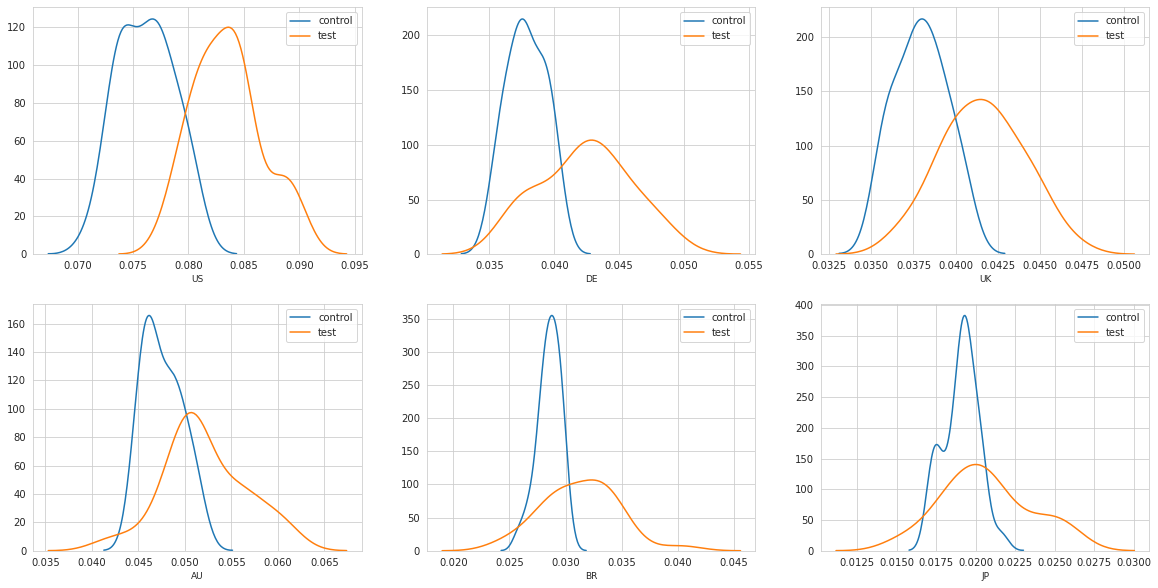

In [31]:
#Density Plots
def plot_feature_density(df1,df2,label1,label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(20,10))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(2,3,i)
        sns.distplot(df1.bpc[(df1['platform']==feature)], hist=False,label=label1)
        sns.distplot(df2.bpc[(df2['platform']==feature)], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=10)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show();
    
features = data.platform.unique().tolist()
plot_feature_density(data[(data['group']=='control') & (data['month']=='may')],data[(data['group']=='test') & (data['month']=='may')],'control','test', features)

# Summary of tests

# Experimentation Month: Feb

**Metric: Clicks Per Visit**
* **Global Level:** No significant change observed
* **Platform Level:** No significant change observed

**Metric: Bookings Per Click**
* **Global Level:** A significant mean difference of -0.24% observed in test group with 95% CI [ -0.41% , -0.07% ]
* **Platform Level:** No significant change observed

# Experimentation Month: May

**Metric: Clicks Per Visit** 
* **Global Level:** A significant mean difference of -2.67% observed in test group with 95% CI [ -2.71% , -2.62% ]
* **Platform Level**
    * US: A significant mean difference of -2.63% observed in test group with 95% CI [ -2.71% , -2.55% ]
    * DE: A significant mean difference of -2.66% observed in test group with 95% CI [ -2.78% , -2.54% ]
    * UK: A significant mean difference of -2.76% observed in test group with 95% CI [ -2.88% , -2.64% ]
    * AU: A significant mean difference of -2.66% observed in test group with 95% CI [ -2.83% , -2.49% ]
    * BR: A significant mean difference of -2.71% observed in test group with 95% CI [ -2.89% , -2.53% ]
    * JP: A significant mean difference of -2.66% observed in test group with 95% CI [ -2.86% , -2.46% ]  
    
**Metric: Bookings Per Click** 
* **Global Level:** A significant mean difference of 0.49% observed in the test group with 95% CI [ 0.33% , 0.65% ]
* **Platform Level**
    * US: A significant mean difference of  0.73% observed in test group with 95% CI [ 0.48% , 0.98% ]
    * DE: A significant mean difference of  0.44% observed in test group with 95% CI [ 0.07% , 0.81% ]
    * UK: A significant mean difference of  0.37% observed in test group with 95% CI [ 0.0% , 0.74% ]
    * No significant difference observed in other platforms
 

Deep-dive analysis to look at the metrics trends in test and control group across weeks during Apr & May experimentation

In [32]:
weekly_platform_data = data.groupby(['platform','month', 'wom', 'group'], as_index=False)['revenue','clicks','visits','bookings','booking_amount'].sum()
weekly_platform_data['month_wk'] = weekly_platform_data['month'] + weekly_platform_data['wom'].astype(str)
weekly_platform_data['cpv'] = round(weekly_platform_data['clicks']/weekly_platform_data['visits'],4)
weekly_platform_data['bpc'] = round(weekly_platform_data['bookings']/weekly_platform_data['clicks'],4)
weekly_platform_data['bpv'] = round(weekly_platform_data['bookings']/weekly_platform_data['visits'],4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [33]:
weekly_data = data.groupby(['month', 'wom', 'group'], as_index=False)['revenue','clicks','visits','bookings','booking_amount'].sum()
weekly_data['month_wk'] = weekly_data['month'] + weekly_data['wom'].astype(str)
weekly_data['cpv'] = round(weekly_data['clicks']/weekly_data['visits'],4)
weekly_data['bpc'] = round(weekly_data['bookings']/weekly_data['clicks'],4)
weekly_data['bpv'] = round(weekly_data['bookings']/weekly_data['visits'],4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Performance of metrics across test and control during feb

<Figure size 432x288 with 0 Axes>

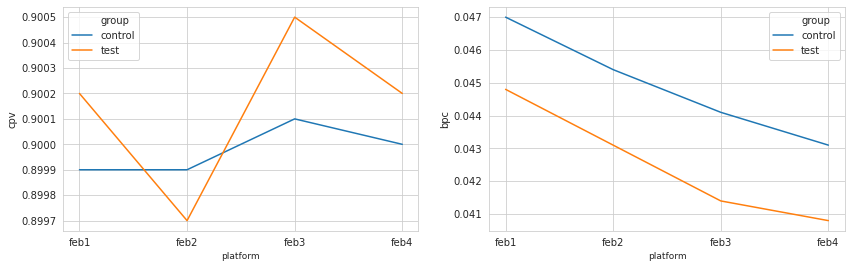

In [34]:
def plot_feature_timeseries(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(14,14))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(3,2,i)
        sns.lineplot(x="month_wk",y=feature,hue="group", data=df, ci=None)
        plt.xlabel("platform", fontsize=9)
    plt.show();
    
features=['cpv','bpc']
plot_feature_timeseries(weekly_data[(weekly_data['month']=='feb')], features)

Above graph shows that 
* CPV in test group is performing well for all weeks in Feb except for 2nd week although with an average difference of 0.0002%
* BPC is consistently below control group's mean by 0.02%


<Figure size 432x288 with 0 Axes>

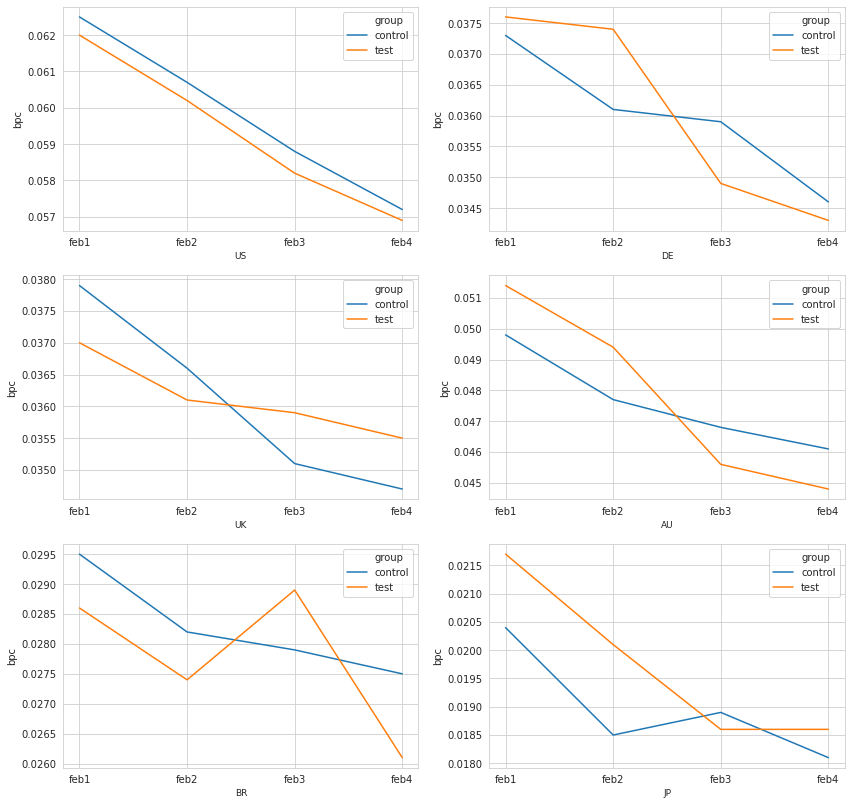

In [35]:
def plot_feature_timeseries(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(14,14))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(3,2,i)
        sns.lineplot(x="month_wk",y='bpc',hue="group", data=df[df['platform']==feature], ci=None)
        plt.xlabel(feature, fontsize=9)
    plt.show();
    
features=weekly_platform_data.platform.unique().tolist()
plot_feature_timeseries(weekly_platform_data[(weekly_platform_data['month']=='feb')], features)

Above graph explains why the BPC metric was significantly low by 0.02% for test group at global level and not at platform level
* The metric shows inconsistent ups and downs at platform level

Performance of metrics across test and control during May

<Figure size 432x288 with 0 Axes>

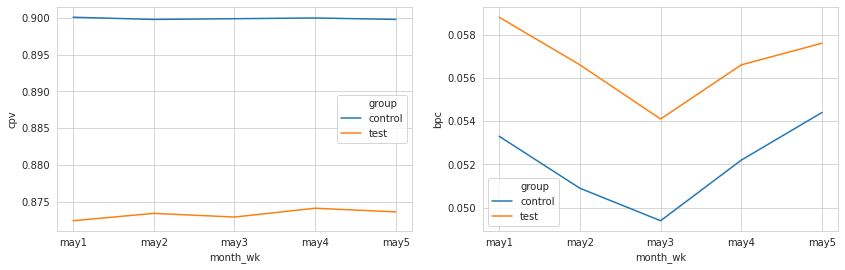

In [36]:
def plot_feature_timeseries(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(14,14))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(3,2,i)
        sns.lineplot(x="month_wk",y=feature,hue="group", data=df, ci=None)
    plt.show();
    
features=['cpv','bpc']
plot_feature_timeseries(weekly_data[(weekly_data['month']=='may')], features)

Above graph shows that
* CPV is consistently less by 2.5% for test group during May
* BPC is consistently higher by 0.5% for test group in the first two weeks, followed by 0.3% towards the rest of the week

# What would be your recommendation regarding the decision for the test?

Let's look at the weekly cumulative lift in metrics during Apr & May to see if there is an increasing or decreasing trend

In [37]:
weekly_pivot = weekly_data.pivot_table(index=["month", "wom"], 
                    columns='group', 
                    values=['cpv','bpc','bpv']).reset_index()

weekly_pivot.columns = [' '.join(col).strip() for col in weekly_pivot.columns.values]

weekly_pivot['cpv_lift'] = round((weekly_pivot['cpv test']-weekly_pivot['cpv control'])*100/weekly_pivot['cpv control'],4)
weekly_pivot['bpc_lift'] = round((weekly_pivot['bpc test']-weekly_pivot['bpc control'])*100/weekly_pivot['bpc control'],4)
weekly_pivot['bpv_lift'] = round((weekly_pivot['bpv test']-weekly_pivot['bpv control'])*100/weekly_pivot['bpv control'],4)

weekly_pivot['cpv_lift_cumsum'] = weekly_pivot['cpv_lift'].cumsum()
weekly_pivot['bpc_lift_cumsum'] = weekly_pivot['bpc_lift'].cumsum()
weekly_pivot['bpv_lift_cumsum'] = weekly_pivot['bpv_lift'].cumsum()

weekly_pivot['month_wk'] = weekly_pivot['month'] + weekly_pivot['wom'].astype(str)

<Figure size 432x288 with 0 Axes>

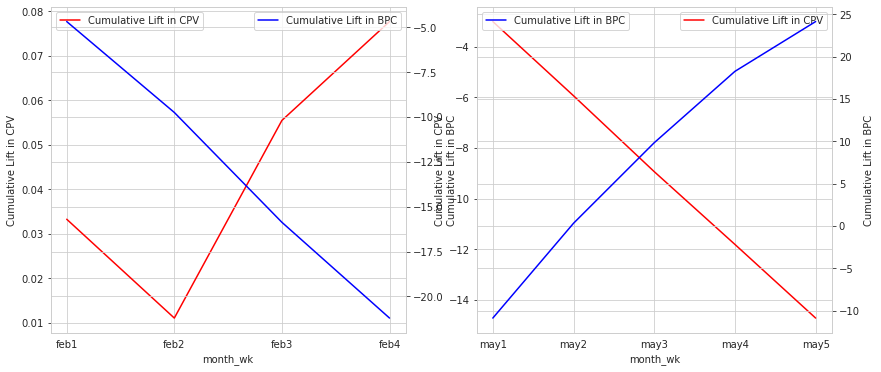

In [38]:
def plot_feature_timeseries(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(14,6))

    for feature in features:
        i += 1
        #print(i)
        plt.subplot(1,2,i)
        ax = sns.lineplot(x="month_wk",y="cpv_lift_cumsum", data=df[df['month']==feature], ci=None, color='r', label="Cumulative Lift in CPV")
        ax.set(ylabel="Cumulative Lift in CPV")
        ax2 = plt.twinx()
        sns.lineplot(x="month_wk",y="bpc_lift_cumsum", data=df[df['month']==feature], ci=None,ax=ax2, color='b', label="Cumulative Lift in BPC")
        ax2.set(ylabel="Cumulative Lift in BPC")
    plt.show();
    
features=['feb','may']
plot_feature_timeseries(weekly_pivot, features)

Above graph show the cumulative lift in each metrics for Apr and May to decide if the AB test should be rolled out or patiently wait for some more time to collect more evidence or develop the feature further.

**Feb Experimentation:**

* At global level, CPV for test group is expected to increase by a weekly lift of +0.02% from the mean CPV of control group in the coming weeks
* At global level, BPC for test is expected to decrease by a weekly lift of -5% from the mean BPC of control group in the coming weeks


**May Experimentation:**
* At global level, CPV for test group is expected to decrease by a weekly lift of -3%  from the mean CPV od control group in the coming weeks
* At global level, BPC for test group is expected to increase by a weekly lift of +7% from the mean BPC of control group in the coming weeks


**Recommendation:**

**Feb:** Run the test for a longer period of time - CPV is expected to show a tiny significant (not practical) lift.

**May:** Develop the feature further before testing again - Since CPV is the major metric for our AB test, the feature has to be developed further.

*Both the features of Feb  & May can be combined together (recommended only from the data perspective) to see overall lift in both the metrics, i.e, the feature that has improved CPV in Feb and BPC in May*

Lift is calculated as (Test Metric - Control Metric)x100/Control Metric
